In [5]:
import pandas as pd
import numpy as np

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [8]:
import re
from collections import Counter

In [9]:
from itertools import zip_longest

In [10]:
df = pd.read_csv("email_marketing_products.csv")
df

,name,rating,reviews,entry_level_price,users,industries,market_segment,pros_themes,pros_counts,cons_themes,cons_counts
0,Constant Contact,4.1,7225,Entry Level Price: Starting at $12.00,Marketing Manager; Owner,Non-Profit Organization Management; Marketing ...,70% Small-Business; 23% Mid-Market,Ease of Use; Easy Creation; Email Marketing; S...,"1,060; 494; 485; 457; 420; 1,060; 494; 485; 45...",Missing Features; Limited Customization; Limit...,280; 255; 246; 212; 185; 280; 255; 246; 212; 185
1,Brevo Marketing Platform,4.5,2477,Entry Level Price: Free,CEO; Founder,Marketing and Advertising; Information Technol...,84% Small-Business; 12% Mid-Market,Ease of Use; Features; Email Marketing; Custom...,439; 266; 248; 203; 198; 439; 266; 248; 203; 198,Missing Features; Limited Features; Limited Cu...,131; 108; 78; 76; 73; 131; 108; 78; 76; 73
2,Intuit Mailchimp Email Marketing,4.3,12859,Entry Level Price: Free,Owner; Marketing Manager,Marketing and Advertising; Non-Profit Organiza...,72% Small-Business; 22% Mid-Market,Ease of Use; Features; Email Marketing; Easy C...,133; 69; 64; 53; 47; 133; 69; 64; 53; 47,Expensive; Learning Curve; Limited Features; L...,38; 34; 30; 23; 22; 38; 34; 30; 23; 22
3,Instantly,4.8,3941,Free trial available,Founder; CEO,Marketing and Advertising; Computer Software,94% Small-Business; 4% Mid-Market,Ease of Use; Customer Support; Helpful; Featur...,"1,826; 1,331; 1,300; 999; 810; 1,826; 1,331; 1...",Missing Features; Expensive; Email Management;...,421; 411; 252; 218; 215; 421; 411; 252; 218; 215
4,Systeme.io,4.8,738,Entry Level Price: Free,Owner; CEO,Marketing and Advertising; Professional Traini...,97% Small-Business; 1% Mid-Market,Ease of Use; Customer Support; Affordable; Fre...,171; 167; 76; 64; 55; 171; 167; 76; 64; 55,Learning Curve; Template Limitations; Limited ...,40; 31; 26; 21; 17; 40; 31; 26; 21; 17
...,...,...,...,...,...,...,...,...,...,...,...
220,Hello Email,4.8,3,NaN,67% Small-Business; 33% Enterprise,67% Small-Business; 33% Enterprise,67% Small-Business; 33% Enterprise,Affordable; Customer Support; Customizability;...,1; 1; 1; 1; 1; 1; 1; 1; 1; 1,NaN,NaN
221,Liana®Cloud Email Marketing,3.2,3,Entry Level Price: Starting at $90.00,100% Small-Business,100% Small-Business,100% Small-Business,NaN,NaN,NaN,NaN
222,LuxSci,4.7,83,Entry Level Price: Contact Us,Mental Health Care; Hospital & Health Care,Mental Health Care; Hospital & Health Care,77% Small-Business; 19% Mid-Market,Customer Support; Security; Ease of Use; HIPAA...,21; 12; 11; 10; 9; 21; 12; 11; 10; 9,Email Issues; Not User-Friendly; UX Improvemen...,5; 5; 5; 4; 4; 5; 5; 5; 4; 4
223,Mailing Manager,4.2,3,Entry Level Price: £45 + VAT per month,33% Enterprise; 33% Mid-Market,33% Enterprise; 33% Mid-Market,33% Enterprise; 33% Mid-Market,NaN,NaN,NaN,NaN


In [11]:
data = df.copy()

In [12]:
def split_themes(x):
    if pd.isna(x):
        return []
    return [t.strip() for t in x.split(";")]

In [13]:
pro_rows = []

In [14]:
for _, row in data.iterrows():
    for theme in split_themes(row["pros_themes"]):
        pro_rows.append({
            "name": row["name"],
            "theme": f"PRO__{theme}"
        })

pros_long = pd.DataFrame(pro_rows)

In [15]:
con_rows = []

for _, row in data.iterrows():
    for theme in split_themes(row["cons_themes"]):
        con_rows.append({
            "name": row["name"],
            "theme": f"CON__{theme}"
        })

cons_long = pd.DataFrame(con_rows)

pros_long.head(), cons_long.head()

(               name                 theme
 0  Constant Contact      PRO__Ease of Use
 1  Constant Contact    PRO__Easy Creation
 2  Constant Contact  PRO__Email Marketing
 3  Constant Contact           PRO__Simple
 4  Constant Contact          PRO__Helpful,
                name                       theme
 0  Constant Contact       CON__Missing Features
 1  Constant Contact  CON__Limited Customization
 2  Constant Contact       CON__Limited Features
 3  Constant Contact      CON__Limited Templates
 4  Constant Contact          CON__Layout Issues)

In [16]:
# Combine pro and con themes
themes_long = pd.concat([pros_long, cons_long], ignore_index=True)

In [17]:
# Build product x theme matrix
feature_matrix = (
    themes_long
    .assign(value=1)
    .pivot_table(
        index="name",
        columns="theme",
        values="value",
        aggfunc="max",
        fill_value=0
    )
)

feature_matrix.shape

(160, 222)

In [18]:
feature_matrix.head()
feature_matrix.sum().sort_values(ascending=False).head(10)

theme
PRO__Ease of Use         133
PRO__Customer Support     79
CON__Missing Features     58
PRO__Email Marketing      47
CON__Expensive            44
PRO__Helpful              43
CON__Learning Curve       40
CON__Limited Features     40
PRO__Automation AI        39
CON__Email Management     35
dtype: int64

In [19]:
# Count how many products each theme appears in
theme_counts = feature_matrix.sum(axis=0)

# Keep themes that appear in at least N products
min_products = 5
themes_to_keep = theme_counts[theme_counts >= min_products].index

feature_matrix_pruned = feature_matrix[themes_to_keep]

feature_matrix_pruned.shape

(160, 50)

In [20]:
feature_matrix_pruned.sum().sort_values(ascending=False).head(15)

theme
PRO__Ease of Use              133
PRO__Customer Support          79
CON__Missing Features          58
PRO__Email Marketing           47
CON__Expensive                 44
PRO__Helpful                   43
CON__Learning Curve            40
CON__Limited Features          40
PRO__Automation AI             39
CON__Email Management          35
PRO__Affordable                33
CON__Poor Customer Support     29
PRO__Easy Creation             27
CON__Limited Customization     22
PRO__Automation                21
dtype: int64

In [21]:
# Check sparsity (percentage of 1s)
density = feature_matrix_pruned.values.mean()
density

np.float64(0.13)

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(feature_matrix_pruned)

similarity_matrix.shape

(160, 160)

In [23]:
sims = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]

sims.min(), sims.mean(), sims.max()

(np.float64(0.0), np.float64(0.27052112820079666), np.float64(1.0))

In [24]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

In [25]:
# Convert similarity to distance
distance_matrix = 1 - similarity_matrix

# Convert to condensed form (required by linkage)
distance_condensed = squareform(distance_matrix, checks=False)

In [26]:
Z = linkage(distance_condensed, method="average")

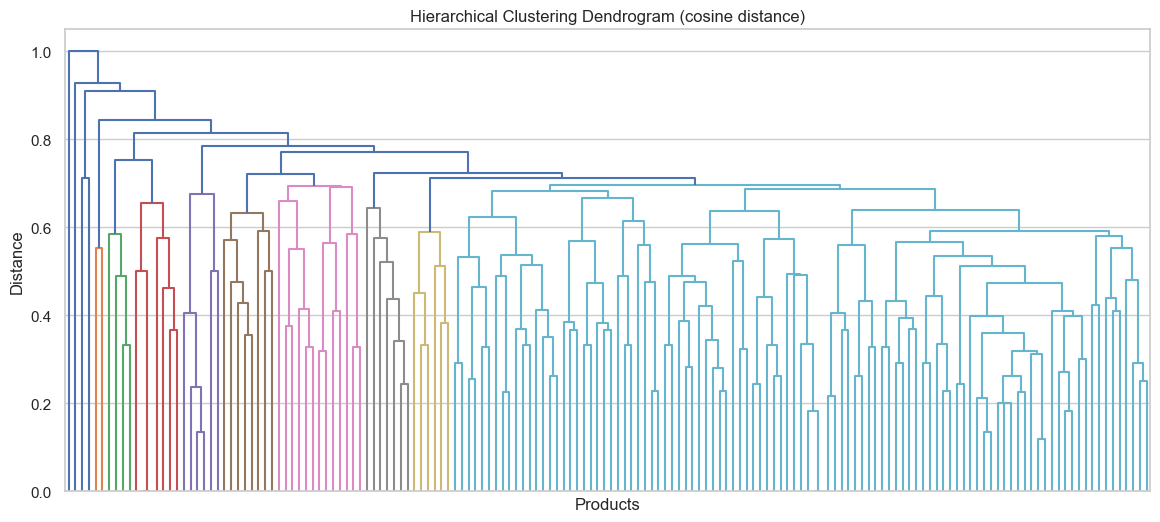

In [27]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    no_labels=True,
    color_threshold=None
)
plt.title("Hierarchical Clustering Dendrogram (cosine distance)")
plt.xlabel("Products")
plt.ylabel("Distance")
plt.show()

In [28]:
from scipy.cluster.hierarchy import fcluster

# Choose cut distance
cut_distance = 0.55

cluster_labels = fcluster(Z, t=cut_distance, criterion="distance")

cluster_labels[:10]

array([10, 42, 42,  8, 35, 10, 38, 11, 11, 37], dtype=int32)

In [29]:
clusters = (
    pd.DataFrame({
        "product": feature_matrix_pruned.index,
        "cluster": cluster_labels
    })
)

clusters["cluster"].value_counts().sort_index()

cluster
1      1
2      1
3      1
4      1
5      3
6      1
7      3
8      3
9      1
10     4
11     2
12     4
13     1
14     2
15     1
16     2
17     3
18     1
19     2
20     2
21     2
22     1
23     5
24     1
25     1
26     3
27     3
28     6
29    10
30     3
31     5
32     3
33     3
34     1
35    10
36     3
37     5
38     6
39     4
40     4
41     6
42    25
43     2
44     3
45     4
46     1
47     1
Name: count, dtype: int64

In [30]:
# Count products per cluster
cluster_sizes = clusters["cluster"].value_counts()

# Keep clusters with at least 3 products
valid_clusters = cluster_sizes[cluster_sizes >= 3].index

valid_clusters, cluster_sizes.loc[valid_clusters]

(Index([42, 29, 35, 38, 41, 28, 37, 31, 23, 10, 39, 12, 40, 45, 33, 30,  7,  5,
        27, 17, 26,  8, 32, 44, 36],
       dtype='int32', name='cluster'),
 cluster
 42    25
 29    10
 35    10
 38     6
 41     6
 28     6
 37     5
 31     5
 23     5
 10     4
 39     4
 12     4
 40     4
 45     4
 33     3
 30     3
 7      3
 5      3
 27     3
 17     3
 26     3
 8      3
 32     3
 44     3
 36     3
 Name: count, dtype: int64)

In [31]:
cluster_id = valid_clusters[0]

cluster_products = clusters.loc[
    clusters["cluster"] == cluster_id, "product"
]

cluster_matrix = feature_matrix_pruned.loc[cluster_products]

cluster_matrix.shape

(25, 50)

In [32]:
# Sum themes inside the cluster
theme_counts_cluster = cluster_matrix.sum().sort_values(ascending=False)

# Separate PRO and CON
top_pro = theme_counts_cluster[theme_counts_cluster.index.str.startswith("PRO__")].head(10)
top_con = theme_counts_cluster[theme_counts_cluster.index.str.startswith("CON__")].head(10)

top_pro, top_con

(theme
 PRO__Ease of Use         25
 PRO__Helpful             22
 PRO__Customer Support    16
 PRO__Features            11
 PRO__Intuitive            6
 PRO__Simple               6
 PRO__Email Marketing      5
 PRO__Affordable           3
 PRO__Customizability      3
 PRO__Automation AI        3
 dtype: int64,
 theme
 CON__Missing Features         24
 CON__Limited Features         16
 CON__Learning Curve           14
 CON__Expensive                 9
 CON__Limited Customization     8
 CON__Email Management          4
 CON__Limited Options           4
 CON__Limited Templates         4
 CON__Poor Customer Support     3
 CON__Template Limitations      2
 dtype: int64)

In [33]:
# cluster sizes
cluster_sizes = clusters["cluster"].value_counts()

# take top 3 largest clusters
top_clusters = cluster_sizes.head(3)
top_clusters

cluster
42    25
29    10
35    10
Name: count, dtype: int64

In [34]:
def describe_cluster(cluster_id, top_n=8):
    products_in_cluster = clusters.loc[
        clusters["cluster"] == cluster_id, "product"
    ]

    cluster_matrix = feature_matrix_pruned.loc[products_in_cluster]

    theme_counts = cluster_matrix.sum().sort_values(ascending=False)

    top_pro = theme_counts[
        theme_counts.index.str.startswith("PRO__")
    ].head(top_n)

    top_con = theme_counts[
        theme_counts.index.str.startswith("CON__")
    ].head(top_n)

    return {
        "cluster_id": cluster_id,
        "size": len(products_in_cluster),
        "top_pro": top_pro,
        "top_con": top_con,
        "products": products_in_cluster.tolist()
    }

In [35]:
c1 = describe_cluster(top_clusters.index[0])
c1["size"], c1["top_pro"], c1["top_con"]

(25,
 theme
 PRO__Ease of Use         25
 PRO__Helpful             22
 PRO__Customer Support    16
 PRO__Features            11
 PRO__Intuitive            6
 PRO__Simple               6
 PRO__Email Marketing      5
 PRO__Affordable           3
 dtype: int64,
 theme
 CON__Missing Features         24
 CON__Limited Features         16
 CON__Learning Curve           14
 CON__Expensive                 9
 CON__Limited Customization     8
 CON__Email Management          4
 CON__Limited Options           4
 CON__Limited Templates         4
 dtype: int64)

In [36]:
c2 = describe_cluster(top_clusters.index[1])
c2["size"], c2["top_pro"], c2["top_con"]

(10,
 theme
 PRO__Ease of Use          10
 PRO__Customer Support      9
 PRO__Easy Setup            8
 PRO__Affordable            5
 PRO__Quick Setup           4
 PRO__Reliability           3
 PRO__Automation AI         2
 PRO__Easy Integrations     2
 dtype: int64,
 theme
 CON__Email Management         6
 CON__Expensive                6
 CON__Poor Customer Support    4
 CON__Missing Features         4
 CON__Limited Features         2
 CON__Slow Performance         1
 CON__Campaign Issues          1
 CON__UX Improvement           1
 dtype: int64)

In [37]:
c3 = describe_cluster(top_clusters.index[2])
c3["size"], c3["top_pro"], c3["top_con"]

(10,
 theme
 PRO__Ease of Use         10
 PRO__Customer Support     7
 PRO__Email Marketing      7
 PRO__Easy Creation        5
 PRO__Easy Integration     4
 PRO__Affordable           4
 PRO__Helpful              3
 PRO__Automation           2
 dtype: int64,
 theme
 CON__Email Management         9
 CON__Campaign Issues          9
 CON__Poor Customer Support    5
 CON__Missing Features         2
 CON__UX Improvement           1
 CON__Template Limitations     1
 CON__Slow Loading             1
 CON__Outdated Design          1
 dtype: int64)

In [38]:
from sklearn.decomposition import PCA

In [39]:
# PCA projection
pca = PCA(n_components=2)
coords = pca.fit_transform(feature_matrix_pruned)

viz_df = pd.DataFrame(
    coords,
    columns=["x", "y"],
    index=feature_matrix_pruned.index
)

viz_df = viz_df.join(clusters.set_index("product"))

In [40]:
important_clusters = top_clusters.index.tolist()

viz_df["highlight"] = viz_df["cluster"].apply(
    lambda x: x if x in important_clusters else "other"
)

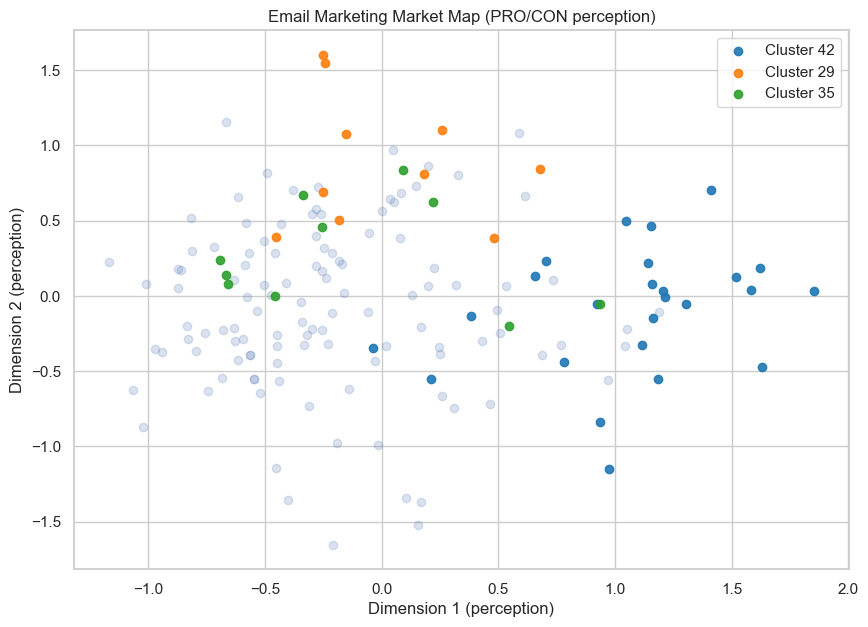

In [41]:
plt.figure(figsize=(10, 7))

# Background (all other products)
bg = viz_df[viz_df["highlight"] == "other"]
plt.scatter(bg["x"], bg["y"], alpha=0.2)

# Highlight clusters
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for cluster_id, color in zip(important_clusters, colors):
    subset = viz_df[viz_df["highlight"] == cluster_id]
    plt.scatter(
        subset["x"],
        subset["y"],
        label=f"Cluster {cluster_id}",
        color=color,
        alpha=0.9
    )

plt.title("Email Marketing Market Map (PRO/CON perception)")
plt.xlabel("Dimension 1 (perception)")
plt.ylabel("Dimension 2 (perception)")
plt.legend()
plt.show()

In [42]:
clusters_sorted = (
    clusters
    .groupby("cluster")["product"]
    .apply(list)
    .reset_index()
    .rename(columns={"product": "products"})
)

clusters_sorted["size"] = clusters_sorted["products"].apply(len)

clusters_sorted = clusters_sorted.sort_values("size", ascending=False)

clusters_sorted

,cluster,products,size
41,42,"[AVADA, AWeber, Constant Contact, ConvesioConv...",25
34,35,"[Alore, CleverReach, EmailOctopus, Frostbite.a...",10
28,29,"[Connect, Hello Email, Mailforge, Mailscale, M...",10
37,38,"[Atomic Mail Sender, BigMailer.io, Campayn, Em...",6
40,41,"[Echobox Email, Everlytic, Moosend, Selzy, Upl...",6
27,28,"[Cybba, Cyberimpact, Hostinger, IONOS 1&1 Doma...",6
22,23,"[CampaignHQ, Hoppy Copy, Mailify, Ongage, Ston...",5
36,37,"[Benchmark Email, Brevo Marketing Platform, Li...",5
30,31,"[CRM.me, Cakemail, Emma by Marigold, MailSend ...",5
11,12,"[GoZen Growth, Mailercloud, cmercury, mailspice]",4


In [43]:
for _, row in clusters_sorted.iterrows():
    print(f"\nCLUSTER {row['cluster']} — {row['size']} products")
    for p in row["products"]:
        print("  •", p)


CLUSTER 42 — 25 products
  • AVADA
  • AWeber
  • Constant Contact
  • ConvesioConvert
  • Dilypse
  • Dotdigital
  • GetResponse
  • Glue Up
  • InboxIgniter
  • Instantly
  • Interseller
  • MailCarry
  • MailerLite
  • Nimble CRM
  • Nutshell
  • Pipedrive
  • Salesforge
  • SendPulse
  • Sender.net
  • Success.ai
  • Systeme.io
  • Xeno
  • Yournotify
  • lemlist
  • plusvibe.ai

CLUSTER 35 — 10 products
  • Alore
  • CleverReach
  • EmailOctopus
  • Frostbite.ai
  • Groupmail
  • Levitate
  • Minutemailer
  • QuickMail
  • Replyify
  • Smartlead

CLUSTER 29 — 10 products
  • Connect
  • Hello Email
  • Mailforge
  • Mailscale
  • Mailtrap
  • Netcore Email API
  • Sendfox
  • Sendy
  • Stampede
  • maildoso

CLUSTER 38 — 6 products
  • Atomic Mail Sender
  • BigMailer.io
  • Campayn
  • EmailCampaigns
  • Robly
  • SendBuzz

CLUSTER 41 — 6 products
  • Echobox Email
  • Everlytic
  • Moosend
  • Selzy
  • Upland Second Street
  • Vision6

CLUSTER 28 — 6 products
  • Cybba
  • Cyb

In [45]:
pros_long = (
    df[["name", "pros_themes"]]
    .dropna(subset=["pros_themes"])
    .assign(theme=lambda x: x["pros_themes"].str.split("; "))
    .explode("theme")
    .drop(columns=["pros_themes"])
)

pros_long.head()

,name,theme
0,Constant Contact,Ease of Use
0,Constant Contact,Easy Creation
0,Constant Contact,Email Marketing
0,Constant Contact,Simple
0,Constant Contact,Helpful


In [48]:
pros_long["theme"].value_counts().head(15)

theme
Ease of Use                266
Customer Support           158
Email Marketing             94
Helpful                     86
Automation AI               78
Affordable                  66
Easy Creation               54
Automation                  42
Simple                      42
Features                    40
Easy Integration            40
Easy Setup                  34
Intuitive                   30
User-Friendly Interface     28
Data Analytics              24
Name: count, dtype: int64

In [49]:
# Split CON themes into long format
cons_long = (
    df[["name", "cons_themes"]]
    .dropna(subset=["cons_themes"])
    .assign(theme=lambda x: x["cons_themes"].str.split("; "))
    .explode("theme")
    .drop(columns=["cons_themes"])
)

cons_long.head()

,name,theme
0,Constant Contact,Missing Features
0,Constant Contact,Limited Customization
0,Constant Contact,Limited Features
0,Constant Contact,Limited Templates
0,Constant Contact,Layout Issues


In [50]:
cons_long["theme"].value_counts().head(15)

theme
Missing Features         116
Expensive                 88
Limited Features          80
Learning Curve            80
Email Management          70
Poor Customer Support     58
Limited Customization     44
Template Limitations      36
Campaign Issues           30
Limited Templates         24
UX Improvement            22
Email Issues              22
Outdated Design           20
Slow Loading              18
Editing Issues            18
Name: count, dtype: int64

In [54]:
pros_all = pros_long.assign(theme=lambda x: "PRO__" + x["theme"])
cons_all = cons_long.assign(theme=lambda x: "CON__" + x["theme"])

themes_long = pd.concat(
    [pros_all[["name", "theme"]],
     cons_all[["name", "theme"]]],
    ignore_index=True
)

themes_long.head(10)

,name,theme
0,Constant Contact,PRO__Ease of Use
1,Constant Contact,PRO__Easy Creation
2,Constant Contact,PRO__Email Marketing
3,Constant Contact,PRO__Simple
4,Constant Contact,PRO__Helpful
5,Constant Contact,PRO__Ease of Use
6,Constant Contact,PRO__Easy Creation
7,Constant Contact,PRO__Email Marketing
8,Constant Contact,PRO__Simple
9,Constant Contact,PRO__Helpful


In [55]:
themes_long["theme"].value_counts().head(15)

theme
PRO__Ease of Use              266
PRO__Customer Support         158
CON__Missing Features         116
PRO__Email Marketing           94
CON__Expensive                 88
PRO__Helpful                   86
CON__Limited Features          80
CON__Learning Curve            80
PRO__Automation AI             78
CON__Email Management          70
PRO__Affordable                66
CON__Poor Customer Support     58
PRO__Easy Creation             54
CON__Limited Customization     44
PRO__Automation                42
Name: count, dtype: int64

In [56]:
presence = (
    themes_long
    .assign(value=1)
    .pivot_table(
        index="name",
        columns="theme",
        values="value",
        aggfunc="max",
        fill_value=0
    )
)

presence.shape

(160, 222)

In [57]:
presence.iloc[:5, :10]

theme,CON__AI Limitations,CON__AI Performance,CON__API Limitations,CON__Access Limitations,CON__Account Management Issues,CON__Audience Management,CON__Audience Targeting,CON__Automation Difficulty,CON__Billing Issues,CON__Bug Issues
name,,,,,,,,,,
1PointMail,0,0,0,0,0,0,0,0,0,0
AVADA,0,0,0,0,0,0,0,0,0,0
AWeber,0,0,0,0,0,0,0,0,0,0
Adobe Journey Optimizer,0,0,0,0,0,0,0,0,0,0
Alore,0,0,0,0,0,0,0,0,0,0


In [58]:
target = "CON__Missing Features"

In [59]:
has_target = presence[target] == 1
n_target = has_target.sum()

pro_cols = [c for c in presence.columns if c.startswith("PRO__")]

rows = []

In [60]:
for pro in pro_cols:
    # how many products have both PRO and Missing Features
    both = ((presence[pro] == 1) & has_target).sum()
    if both == 0:
        continue

    # P(PRO | Missing Features)
    p_pro_given_target = both / n_target

    # P(PRO) in the whole market
    p_pro = presence[pro].mean()

    # lift
    lift = p_pro_given_target / p_pro if p_pro > 0 else np.nan

    rows.append({
        "pro_theme": pro.replace("PRO__", ""),
        "products_with_missing": both,
        "p_pro_given_missing": round(p_pro_given_target, 3),
        "lift": round(lift, 3)
    })

missing_pro = (
    pd.DataFrame(rows)
    .sort_values(
        ["products_with_missing", "lift"],
        ascending=False
    )
)

missing_pro.head(15)

,pro_theme,products_with_missing,p_pro_given_missing,lift
17,Ease of Use,55,0.948,1.141
13,Customer Support,32,0.552,1.117
33,Helpful,26,0.448,1.668
27,Email Marketing,19,0.328,1.115
30,Features,13,0.224,1.793
18,Easy Creation,13,0.224,1.328
36,Intuitive,12,0.207,2.207
4,Automation AI,10,0.172,0.707
24,Easy Setup,9,0.155,1.460
3,Automation,9,0.155,1.182


In [61]:
con_presence = (
    cons_long
    .assign(value=1)
    .pivot_table(
        index="name",
        columns="theme",
        values="value",
        aggfunc="max",
        fill_value=0
    )
)

con_presence.shape

(145, 130)

In [62]:
con_presence.sum().sort_values(ascending=False).head(10)

theme
Missing Features         58
Expensive                44
Learning Curve           40
Limited Features         40
Email Management         35
Poor Customer Support    29
Limited Customization    22
Template Limitations     18
Campaign Issues          15
Limited Templates        12
dtype: int64

In [64]:
import itertools

In [65]:
pairs = []

themes = con_presence.columns.tolist()

for t1, t2 in itertools.combinations(themes, 2):
    both = ((con_presence[t1] == 1) & (con_presence[t2] == 1)).sum()
    if both > 0:
        pairs.append({
            "con_1": t1,
            "con_2": t2,
            "products_with_both": both
        })

con_pairs = pd.DataFrame(pairs)
con_pairs.sort_values("products_with_both", ascending=False).head(10)

,con_1,con_2,products_with_both
471,Limited Features,Missing Features,25
433,Learning Curve,Missing Features,20
346,Expensive,Missing Features,14
307,Email Management,Missing Features,14
297,Email Management,Expensive,12
336,Expensive,Learning Curve,12
349,Expensive,Poor Customer Support,12
340,Expensive,Limited Features,11
72,Campaign Issues,Email Management,11
453,Limited Customization,Limited Features,11


In [68]:
rows = []

con_cols = [c for c in con_presence.columns if c != target]

for con in con_cols:
    both = ((con_presence[con] == 1) & has_target).sum()
    if both < 5:   # 🔴 критично: фильтр по поддержке
        continue

    p_con_given_target = both / n_target
    p_con = con_presence[con].mean()

    lift = p_con_given_target / p_con if p_con > 0 else np.nan

    rows.append({
        "con_theme": con,
        "products_with_both": both,
        "p_con_given_missing": round(p_con_given_target, 3),
        "lift": round(lift, 3)
    })

missing_con = (
    pd.DataFrame(rows)
    .sort_values(["products_with_both", "lift"], ascending=False)
)

missing_con.head(15)

,con_theme,products_with_both,p_con_given_missing,lift
7,Missing Features,58,1.000,2.500
5,Limited Features,25,0.431,1.562
3,Learning Curve,20,0.345,1.250
1,Email Management,14,0.241,1.000
2,Expensive,14,0.241,0.795
4,Limited Customization,10,0.172,1.136
0,Email Issues,9,0.155,2.045
6,Limited Templates,9,0.155,1.875
9,Template Limitations,9,0.155,1.250
8,Poor Customer Support,9,0.155,0.776
